In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN, SMOTE
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!pip install catboost

     |████████████████████████████████| 64.4MB 45kB/s 


In [0]:
import catboost
import lightgbm

In [0]:
X = pd.read_csv("/content/drive/My Drive/antifraud/agg/train_data.csv")

In [0]:
X["policy_action"] = LabelEncoder().fit_transform(X["policy_action"])

In [6]:
X

event_id     user_id  ...   sum.1  count.1
0       edb52e6958d54f53ba737da0c4b4d17a     2676263  ...   65000        1
1       78fe81fb512f4d78a6a2071b9e29e122    25176094  ...  120000        1
2       c65dd6dd795244889798c618f2f51c21    70860625  ...   35000        1
3       c2153ef1a2fc4160ac51f5321245c9d2    18105863  ...  825000        6
4       4fa8d69664854ef382103f4b7233e983   109792460  ...  692302        7
...                                  ...         ...  ...     ...      ...
214885  3caf12cd496e45968c4f49a4c9e906ce    60668115  ...   60000        1
214886  4cf1fa2b71994f588ce65abf683be807    39755315  ...   58600        1
214887  045d5a11009d4e0bac0121d9d10a0686      239018  ...   77000        1
214888  55eecfca2af144a784937ca0be969e0e    77400172  ...    1700        1
214889  08a7946af03249d192416c31fb6b7e60  MBK8854275  ...   17290        1

[214890 rows x 448 columns]

In [0]:
def tr_tst_split(tr):
    genue = tr[tr["class"] == 0].sort_values("user_id_rcvr")
    fraud = tr[tr["class"] == 1].sort_values("user_id_rcvr")
    
    fraud_tr, fraud_tst = train_test_split(fraud, test_size = 0.2, shuffle = False)
    genue_tr, genue_tst = train_test_split(genue, test_size = 0.2, shuffle = False)
    print(len(set(fraud_tr.user_id_rcvr).intersection(fraud_tst.user_id_rcvr)))
    print(len(set(fraud_tr.user_id).intersection(fraud_tst.user_id)))
    
    return pd.concat([fraud_tr, genue_tr]), pd.concat([fraud_tst, genue_tst])

In [0]:
def get_X_y(X):
  return X.drop(["event_id", "user_id",	"user_id_rcvr", "class",
                "risk_score","policy_action"], axis = 1), X["class"]

Визуализируем транзакции

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
X_to_reduce, y = get_X_y(X.dropna())

In [0]:
X_to_reduce = StandardScaler().fit_transform(X_to_reduce)

In [0]:
reducer = umap.UMAP()

In [27]:
X_reduced = reducer.fit_transform(X_to_reduce)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^


/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candida

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_reduced[:,0], y=X_reduced[:,1],mode = 'markers'))
fig.add_trace(go.Scatter(x=X_reduced[:,0][y==1], y=X_reduced[:,1][y==1], mode = 'markers', opacity=0.9))
fig.show()

Обучение модели

In [9]:
X_tr, X_tst = tr_tst_split(X)

0
39


In [10]:
X_tr

event_id    user_id  ...   sum.1  count.1
8613    eeee05f7945146698fd45d9f8b4c21c5   58071906  ...   48000        1
183220  7d5d8c0d10c6472cbe2eec5c22d9358f   54135391  ...    6400        1
28703   6c58283e7b7d41e4a9da0b2c9d4348a0   58173006  ...    9500        1
206245  3860d3746c3b494faf4b164aef74ff12   80745153  ...    3500        1
201765  ca1e9baa5af64da38118ffc62f57904d  110137607  ...    4163        1
...                                  ...        ...  ...     ...      ...
93541   5e2a3813cadf4f09b002ca14669b1fe2      39976  ...   82000        1
210103  76425605d07b42afac7ffa57a81ddfb2   37970504  ...   59000        1
10766   4eee08db726c404191596b1a7669c27f   12470241  ...  102800        1
178161  a14746ce3b3946b79ce61e5f246aa4c9   18207893  ...  100000        1
26055   344bfc84dea341b8b0238f6d95411673   82308164  ...  130000        1

[171911 rows x 448 columns]

In [0]:
X_tr, y_tr = get_X_y(X_tr)

In [0]:
md_catboost = catboost.CatBoostClassifier(task_type='GPU', verbose=0)
md_lgbm = lightgbm.LGBMClassifier()

In [13]:
md_catboost.fit(X_tr, y_tr)

md_lgbm.fit(X_tr, y_tr)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
X_tst, y_tst = get_X_y(X_tst)

In [0]:
preds_catboost = md_catboost.predict_proba(X_tst)
preds_lgbm = md_lgbm.predict_proba(X_tst)

In [0]:
pr_cat, rc_cat, _ = precision_recall_curve(y_tst, preds_catboost[:,1])
pr_lgbm, rc_lgbm, _ = precision_recall_curve(y_tst, preds_lgbm[:,1])

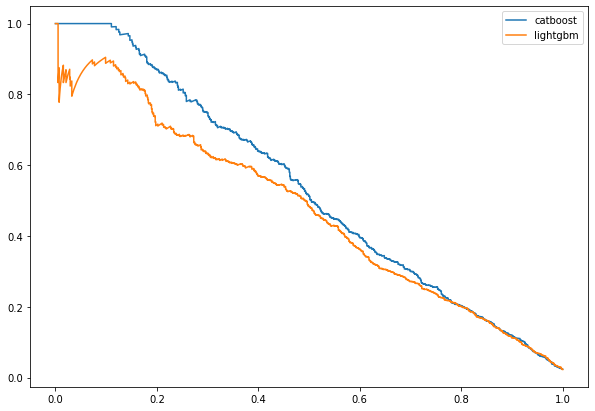

In [17]:
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(rc_cat, pr_cat)
ax.plot(rc_lgbm, pr_lgbm)
ax.legend(["catboost", "lightgbm"])

In [18]:
pr_cat[rc_cat>0.6]

array([0.0234837 , 0.02345984, 0.02346041, ..., 0.39601922, 0.39629121,
       0.39656357])

Catboost дает recall = 0.6, precision = 0.3

In [19]:
X_tr

amount_original   event_time_  ...   sum.1  count.1
8613              48000  1.554491e+09  ...   48000        1
183220             6400  1.554558e+09  ...    6400        1
28703              9500  1.554658e+09  ...    9500        1
206245             3500  1.554650e+09  ...    3500        1
201765             4163  1.554453e+09  ...    4163        1
...                 ...           ...  ...     ...      ...
93541             82000  1.555071e+09  ...   82000        1
210103            59000  1.554454e+09  ...   59000        1
10766            102800  1.554199e+09  ...  102800        1
178161           100000  1.555220e+09  ...  100000        1
26055            130000  1.556619e+09  ...  130000        1

[171911 rows x 442 columns]

In [0]:
features = list(zip(X_tr.columns, md_catboost.feature_importances_))
features.sort(key = lambda x:-x[1])

In [22]:
features

[('amount_original', 13.056862060427338),
 ('sum', 10.30707076620973),
 ('count', 6.086055816437767),
 ('user_defined_event_type mean POS_PURCHASE.1', 2.8748554004858895),
 ('mcc_group mean R distr.1', 2.821547255600771),
 ('count.1', 2.3448280232821666),
 ('user_defined_event_type count ATM_P2P_CREDIT.1', 2.3274232571748055),
 ('event_time_', 2.315239820203227),
 ('user_defined_event_type count ATM_P2P_CREDIT distr.1', 1.5387231413893725),
 ('user_defined_event_type count ATM_BALANCE.1', 1.4965794822590273),
 ('mu.1', 1.266807104351718),
 ('user_defined_event_type count ATM_BALANCE distr.1', 1.207351527050388),
 ('event_type mean PAYMENT.1', 1.1847597867191877),
 ('event_type mean DEPOSIT.1', 1.0528980028990265),
 ('user_defined_event_type count ATM_SERVICE_ON.1', 0.8516320776098252),
 ('mcc_group mean C.1', 0.8318386099849362),
 ('event_type count UPDATE_USER.1', 0.7983140003197078),
 ('mcc_group count C distr.1', 0.7924847357611529),
 ('mcc_group count C.1', 0.7812760920876454),
 ('